<a href="https://colab.research.google.com/github/amar9929-3/Bioinformatics_Project/blob/main/Notebooks/ML_Christian_Tester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Setup and Imports

In [1]:
# If running on Colab, install anything missing
try:
    import umap
except Exception:
    %pip -q install umap-learn scikit-learn matplotlib pandas numpy

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Simulated Data

In [3]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv('simulated_group_conditioned.csv')
df.head()

Saving simulated_group_conditioned.csv to simulated_group_conditioned.csv


,@#,River,Predation,Population,Lengthmm,Weightg,BMI,EyeSizemm,InternalParasite#,BrainWeightg
0,AR.HP.25,EC,KO,AMHP,42,0.166140,0.841119,2.166681,4,0.006072
1,AM.RO.17,AP,HP,APHP,29,0.083000,0.754529,1.535650,3,0.003208
2,AM.RO.01,AP,KO,APHP,46,0.588084,0.968317,2.845715,3,0.009100
3,AR.RO.25,AM,KO,APHP,22,0.083000,0.830582,1.674321,2,0.004103
4,AR.HP.10,AP,KO,APKO,36,0.390498,0.839801,1.775865,0,0.006911


## Normalizing Data

In [4]:
#Log transform the data
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df_log_scaled = df.copy()

# Log transform
df_log_scaled[numeric_cols] = np.log1p(df[numeric_cols])  # log(x+1)

# Z-score scale
scaler = StandardScaler()
df_log_scaled[numeric_cols] = scaler.fit_transform(df_log_scaled[numeric_cols])

df_log_scaled.head()

,@#,River,Predation,Population,Lengthmm,Weightg,BMI,EyeSizemm,InternalParasite#,BrainWeightg
0,AR.HP.25,EC,KO,AMHP,0.007204,-1.090803,-0.185861,-0.415531,0.690508,-0.741235
1,AM.RO.17,AP,HP,APHP,-1.011023,-1.269202,-0.907818,-1.410761,0.446245,-1.248158
2,AM.RO.01,AP,KO,APHP,0.258782,-0.345925,0.815316,0.454492,0.446245,-0.206862
3,AR.RO.25,AM,KO,APHP,-1.762534,-1.269202,-0.271879,-1.172312,0.131335,-1.089619
4,AR.HP.10,AP,KO,APKO,-0.417852,-0.666391,-0.196596,-1.005421,-1.071257,-0.593088


## Train/Test Split

In [5]:
X = df.drop(['@#', 'River', 'Predation', 'Population', 'Lengthmm', 'Weightg'], axis=1)
y = df['Population']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Running Unsupervised Methods for Visualization

## PCA

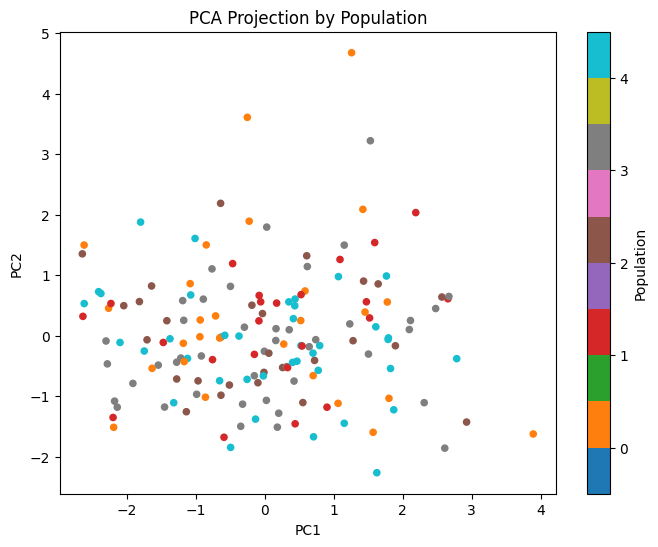

In [6]:
# Encode
X = pd.get_dummies(X_train, drop_first=True)

# Scale
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

le = LabelEncoder()
y_numeric = le.fit_transform(y_train)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_numeric, cmap='tab10', s=20)
plt.colorbar(ticks=range(len(le.classes_)), label='Population')
plt.clim(-0.5, len(le.classes_)-0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection by Population")
plt.show()

## UMAP

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


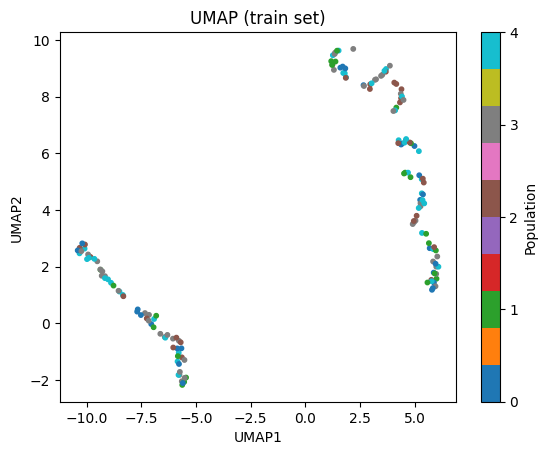

In [7]:
# UMAP
um = umap.UMAP(n_components=2, random_state=RANDOM_STATE, n_neighbors=15, min_dist=0.1)
UM = um.fit_transform(X)

# Plot
plt.figure()
scatter = plt.scatter(UM[:, 0], UM[:, 1], c=y_numeric, cmap='tab10', s=10)
plt.colorbar(ticks=range(len(le.classes_)), label='Population')
plt.title("UMAP (train set)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

## t-SNE

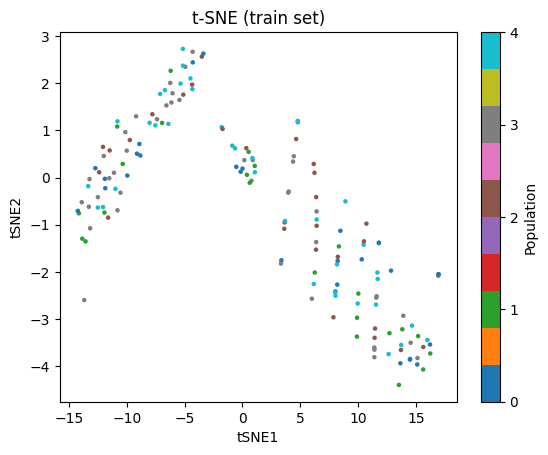

In [8]:
# t-SNE
ts = TSNE(n_components=2, random_state=RANDOM_STATE, init="pca", learning_rate="auto", perplexity=30)
TS = ts.fit_transform(X)

# Plot
plt.figure()
plt.scatter(TS[:,0], TS[:,1], c=y_numeric, cmap='tab10', s=5)
plt.colorbar(ticks=range(len(le.classes_)), label='Population')
plt.title("t-SNE (train set)")
plt.xlabel("tSNE1"); plt.ylabel("tSNE2")
plt.show()

# Training Supervised Methods on Simulated Data

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd
import numpy as np

# Assuming RANDOM_STATE, X_train, X_test, y_train, y_test are already defined

models = {
    "LogReg": Pipeline([("scaler", StandardScaler()),
                        ("clf", LogisticRegression(max_iter=500, multi_class="auto", random_state=RANDOM_STATE))]),
    "RF":     Pipeline([("clf", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE))]),
    "SVM":    Pipeline([("scaler", StandardScaler()),
                        ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))]),
}


results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)
    acc = accuracy_score(y_test, pred)
    try:
        auc = roc_auc_score(y_test, proba, multi_class="ovr")
    except Exception:
        auc = np.nan
    results[name] = {"accuracy": acc, "roc_auc_ovr": auc}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


        accuracy  roc_auc_ovr
LogReg  0.206897     0.390576
RF      0.206897     0.462367
SVM     0.310345     0.583916


# Confusion Matrix of the Best Model

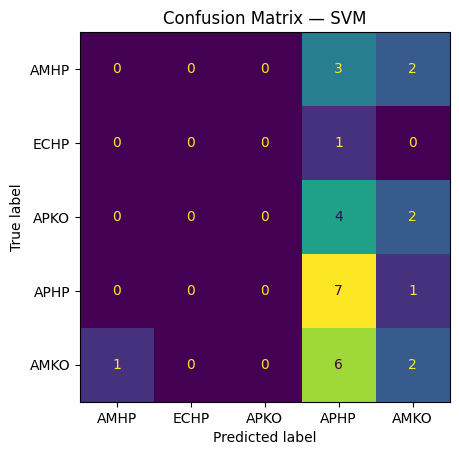

              precision    recall  f1-score   support

        AMHP       0.00      0.00      0.00         5
        ECHP       0.00      0.00      0.00         1
        APKO       0.00      0.00      0.00         6
        APHP       0.33      0.88      0.48         8
        AMKO       0.29      0.22      0.25         9

    accuracy                           0.31        29
   macro avg       0.12      0.22      0.15        29
weighted avg       0.18      0.31      0.21        29



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
best = max(results.items(), key=lambda kv: kv[1]["accuracy"])[0]
best_pipe = models[best]
pred = best_pipe.predict(X_test)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=y_test.unique())
fig, ax = plt.subplots()
disp.plot(ax=ax, colorbar=False)
plt.title(f"Confusion Matrix — {best}")
plt.show()

print(classification_report(y_test, pred, target_names=y_test.unique()))

# Cross-Validate Training

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid = {
    "LogReg": {"clf__C":[0.1,1,10]},
    "RF":     {"clf__n_estimators":[200,400], "clf__max_depth":[None,10]},
    "SVM":    {"clf__C":[0.5,1,2], "clf__gamma":["scale","auto"]},
}

tuned = {}
for name, pipe in models.items():
    grid = GridSearchCV(pipe, param_grid[name], cv=cv, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    tuned[name] = {"best_score": grid.best_score_, "best_params": grid.best_params_, "estimator": grid.best_estimator_}

pd.DataFrame({k: {"cv_best_acc": v["best_score"], **v["best_params"]} for k,v in tuned.items()}).T

# ROC Curves

In [ ]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

best_name = max(tuned.items(), key=lambda kv: kv[1]["best_score"])[0]
est = tuned[best_name]["estimator"].fit(X_train, y_train)
y_score = est.predict_proba(X_test)

y_bin = label_binarize(y_test, classes=np.unique(y_train))
fig = plt.figure()
RocCurveDisplay.from_predictions(y_bin.ravel(), y_score.ravel())
plt.title(f"ROC AUC (OvR) — {best_name}")
plt.show()

# Final Analysis with Most Accurate Classifier

## Real Data

In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv('Anne.csv')
df.head()

## Normalizing Real Data

In [ ]:
#Log transform the data
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df_log_scaled = df.copy()

# Log transform
df_log_scaled[numeric_cols] = np.log1p(df[numeric_cols])  # log(x+1)

# Z-score scale
scaler = StandardScaler()
df_log_scaled[numeric_cols] = scaler.fit_transform(df_log_scaled[numeric_cols])

df_log_scaled.head()

## Train/Split Real Data

In [ ]:
X = df.drop(['@#', 'River', 'Predation', 'Population', 'Lengthmm', 'Weightg'], axis=1)
y = df['Population']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

## Classifier Name

In [ ]:
# Choose Most Accurate Classifier

## Final UMAP

In [ ]:
# --- UMAP plot colored by category (train fit only) ---

import numpy as np
import matplotlib.pyplot as plt

# If umap wasn't imported earlier:
try:
    umap.UMAP
except NameError:
    import umap

# 1) Standardize using training data only (to avoid leakage)
scaler_vis = StandardScaler().fit(X_train)
Xtr_z = scaler_vis.transform(X_train)
Xte_z = scaler_vis.transform(X_test)

# 2) Fit UMAP on TRAIN, then transform TEST
um_vis = umap.UMAP(n_components=2, random_state=RANDOM_STATE, n_neighbors=15, min_dist=0.1)
UM_tr = um_vis.fit_transform(Xtr_z)
UM_te = um_vis.transform(Xte_z)

# 3) Plot, color by class labels
classes = np.unique(y_train)
plt.figure(figsize=(6,5))

for c in classes:
    idx_tr = (y_train == c)
    plt.scatter(UM_tr[idx_tr,0], UM_tr[idx_tr,1],
                s=18, alpha=0.85, label=f"train: {c}")

# Optionally overlay the test set with hollow markers
for c in np.unique(y_test):
    idx_te = (y_test == c)
    plt.scatter(UM_te[idx_te,0], UM_te[idx_te,1],
                s=36, alpha=0.85, facecolors='none', edgecolors='k', linewidths=0.7,
                label=f"test: {c}")

plt.title("UMAP embedding colored by Population\n(fit on train, transformed test)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(loc="best", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()